In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.ndimage import gaussian_filter
from PIL import Image

%matplotlib inline

random = np.random.default_rng()

# Dataset generation

## Defining the functions for image generation

In [5]:
def get_transformed_coordinates(max_width, max_height):
    """The idea for generating geometric shapes is to take a standard
    shape (like the circle x^2 + y^2 < 1) and then apply a sequence of
    transformations to turn it into a randomly positioned, stretched,
    and rotated shape (like an ellipse). The way to do this is to apply
    the inverse transformations in reverse order to a coordinate grid.
    This function creates such a transformed coordinate grid. We first
    translate, then rotate, then scale, and finally flip. So the
    geometrical shape is first flipped, then scaled, then rotated, and
    finally translated.
    """
    x = np.arange(max_width)
    y = np.arange(max_height)
    
    xx, yy = np.meshgrid(x, y)
    
    # The center of the shape will be at (cx, cy).
    cx = random.integers(max_width  // 4, 3 * max_width  // 4)
    cy = random.integers(max_height // 4, 3 * max_height // 4)
    
    # The shape will be rotated at angle theta.
    theta = np.pi / 2 * random.random()   
    
    # Next, we calculate the length of the axes of the shape. We need
    # to take into consideration the angle when calculating the upper
    # bounds.
    max_width  = np.minimum(int(cx / np.sin(theta)), int(cy / np.cos(theta)))
    max_height = np.minimum(int(cx / np.cos(theta)), int(cy / np.sin(theta)))
    
    width  = random.integers(1 , max_width)
    height = random.integers(1, max_height)
    
    # Translation to aligh with the center
    xx -= cx
    yy -= cy
    
    # Rotation according to theta
    xx, yy = xx * np.cos(theta) + yy * np.sin(theta), \
             xx * np.sin(theta) - yy * np.cos(theta)
    
    # Scale according to the specified width and height
    xx /= width / 2
    yy /= height / 2
    
    # Flip over x- and y-axes. Get a random 2-bit integer, and read off
    # each bit as a bool.
    flip = random.integers(0, 4, 1)
    
    if flip & 1:
        xx = xx[::-1]
        yy = yy[::-1]
    if flip & 2:
        xx = xx[:,::-1]
        yy = yy[:,::-1]
    
    return xx, yy

def soften_edges(dist, cutoff):
    """d is an array containing the distance (in some metric) of its
    coordinates to some point. This function is meant to provide a smoother
    version of the function that is 1 if "d <= cutoff" and 0 otherwise."""
    
    return 1/(1+np.exp(10 * (dist - cutoff)))

def get_random_ellipse(max_width, max_height):
    """Return an arry of size width x height with value 1 inside an ellipse
    and 0 outside. The dimensions and radius of the ellipse are random."""
    xx, yy = get_transformed_coordinates(max_width, max_height)
    
#     print(f"ellipse xx, yy: {xx}, {yy}")
    
    return xx**2 + yy**2 <= 1

#     dist = xx**2 + yy**2
#     return soften_edges(dist, cutoff=1)

def get_random_rectangle(max_width, max_height):
    """Return an arry of size width x height with value 1 inside an ellipse
    and 0 outside. The dimensions and radius of the ellipse are random."""
    xx, yy = get_transformed_coordinates(max_width, max_height)
    
#     print(f"rectangle xx, yy: {xx}, {yy}")
    
    return np.maximum(np.abs(xx), np.abs(yy)) <= 1
#     dist = np.maximum(np.abs(xx), np.abs(yy))

#     return soften_edges(dist, cutoff=1)

def get_random_triangle(max_width, max_height):
    xx, yy = get_transformed_coordinates(max_width, max_height)
    xx /= np.sqrt(2)
    yy /= np.sqrt(2)
    
    return np.logical_and(np.abs(xx) + np.abs(yy) <= 1, xx > 0)

def construct_random_image(max_width, max_height):
    # We render the images at a higher resolution and then downscale for
    # anti-aliasing. "rf" is for "render factor".
    rf = 4
    
    arr = np.zeros((rf * max_width, rf * max_height), dtype=np.float64)
    
    funcs = [get_random_ellipse, get_random_rectangle, get_random_triangle]
    
    for f in random.choice(funcs, random.integers(3, 4)):
        arr += f(rf * max_width, rf * max_height) / 3
    
    image = Image.fromarray(arr)
    image = image.resize((max_width, max_height), resample=Image.ANTIALIAS)

    return np.array(image)


## Testing the image generation

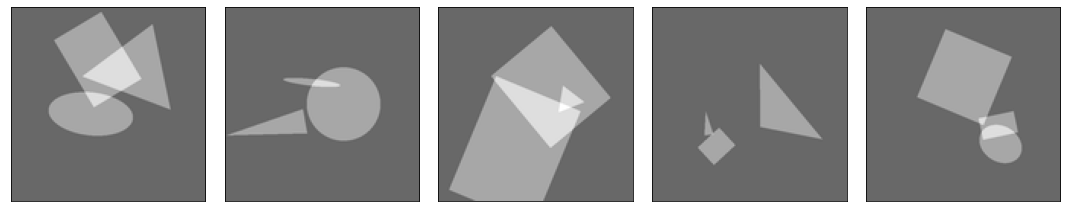

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for ax1, ax2 in zip(axs.flat[:5], range(100)):
    image = 0.01 * construct_random_image(128, 128)
#     noisy_image = add_scan_noise(image, I_0=10000)
    
    ax1.imshow(image, vmin=-0.005, vmax=0.01, cmap=plt.cm.Greys_r)
#     ax2.imshow(noisy_image, vmin=-0.005, vmax=0.01, cmap=plt.cm.Greys_r)
    
    ax1.set_xticks([])
    ax1.set_yticks([])
#     ax2.set_xticks([])
#     ax2.set_yticks([])
    
fig.tight_layout()

plt.savefig('shapes.png')

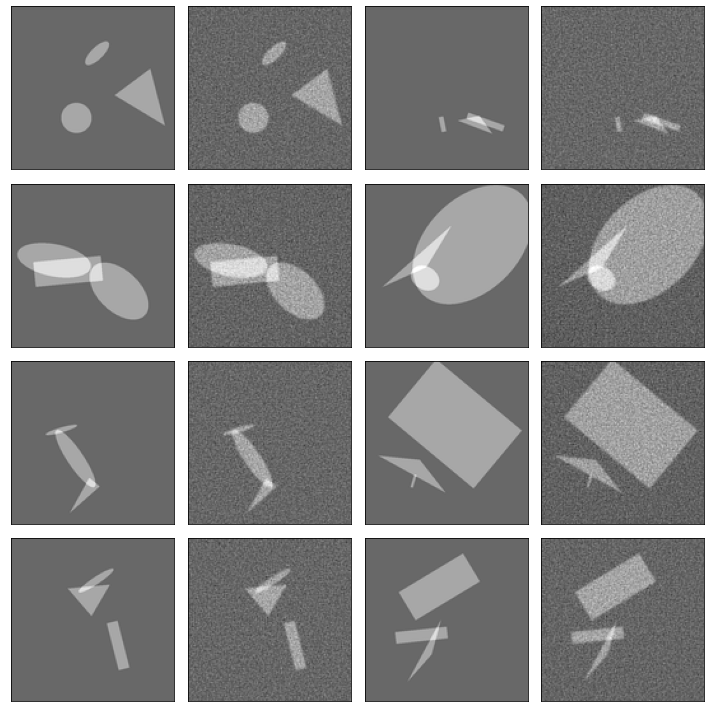

In [4]:
from radontools import add_scan_noise

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for ax1, ax2 in zip(axs.flat[::2], axs.flat[1::2]):
    image = 0.01 * construct_random_image(128, 128)
    noisy_image = add_scan_noise(image, I_0=10000)
    
    ax1.imshow(image, vmin=-0.005, vmax=0.01, cmap=plt.cm.Greys_r)
    ax2.imshow(noisy_image, vmin=-0.005, vmax=0.01, cmap=plt.cm.Greys_r)
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
fig.tight_layout()

## Trying out different levels of noise

In [5]:
np.logspace(100, 100000, len(axs.flat))

/home/jeroenvdb/.local/lib/python3.10/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


array([1.e+100,     inf,     inf,     inf,     inf,     inf,     inf,
           inf,     inf,     inf,     inf,     inf,     inf,     inf,
           inf,     inf])

In [60]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

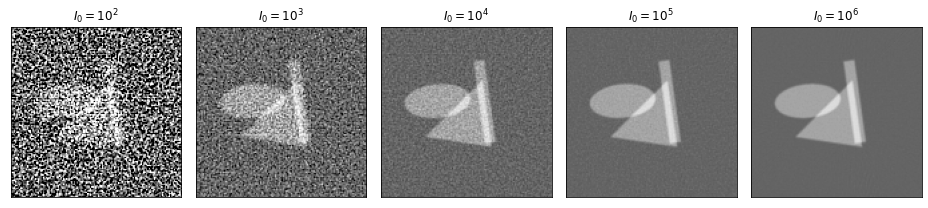

In [30]:
from radontools import add_scan_noise

fig, axs = plt.subplots(1, 5, figsize=(13, 3))

image = 0.01 * construct_random_image(128, 128)

for ax, log_I_0 in zip(axs.flat, np.linspace(2, 6, len(axs.flat), dtype=int)):
    noisy_image = add_scan_noise(image, I_0=10**log_I_0)
    
    ax.imshow(noisy_image, vmin=-0.005, vmax=0.01, cmap=plt.cm.Greys_r)
    
    ax.set_title(f"$I_0 = 10^{{{log_I_0}}}$")
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

plt.savefig('noise-levels.png')

## Generate the shapes dataset and save to file

In [5]:
path = "shapes-dataset.npz"

In [11]:
from radontools import add_scan_noise

path = "shapes-dataset.npz"

dataset = list()

for i in range(512):
    true_image  = 0.01 * construct_random_image(128, 128)
    noisy_image = add_scan_noise(true_image, I_0=10000)
    
    dataset.append(np.array([true_image, noisy_image]))

np.savez(path, *dataset)

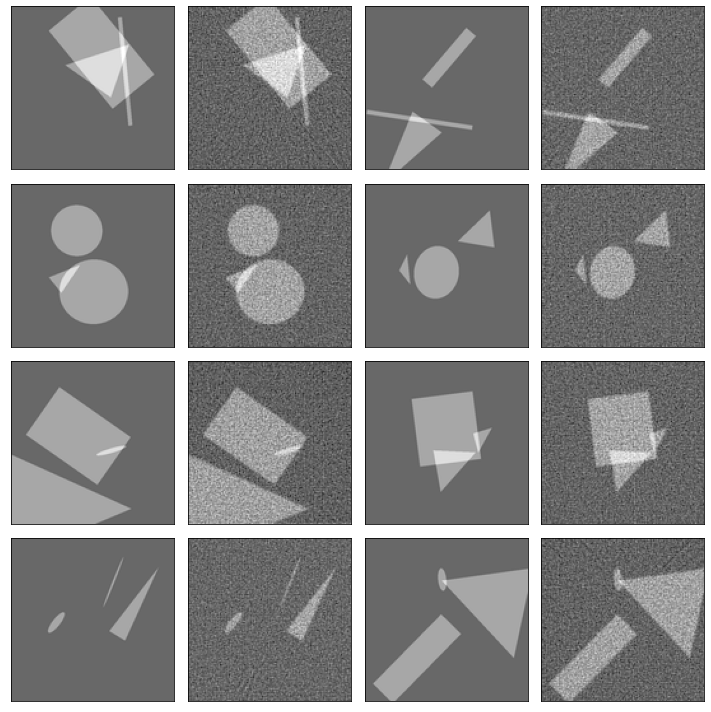

In [7]:
npzfile = np.load(path)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, (ax1, ax2) in enumerate(zip(axs.flat[::2], axs.flat[1::2])):
    true_image = npzfile[npzfile.files[i]][0]
    noisy_image = npzfile[npzfile.files[i]][1]
    
    ax1.imshow(true_image, vmin=-0.005, vmax=0.01, cmap=plt.cm.Greys_r)
    ax2.imshow(noisy_image, vmin=-0.005, vmax=0.01, cmap=plt.cm.Greys_r)
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
fig.tight_layout()